# Sentiment Classification using BERT

## Introduction

BERT (Bidirectional Encoder Representations from Transformers) is a deep learning model developed by Google in 2018 for natural language processing.
It uses a transformer architecture to understand the context of words by looking at both the left and right surrounding words (bidirectional), enabling state-of-the-art performance in tasks like question answering, sentiment analysis, and language inference.

## Import Libraries

In [4]:
import yahoo_fin.stock_info as si
from yahoo_fin import options
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
import ktrain
from ktrain import text
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import datetime

/usr/local/lib/python3.6/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


## Import Data

In [10]:
# Training Data 
data_train = pd.read_excel('/content/train.xlsx', dtype=str)
data_train.head()

,Reviews,Sentiment
0,"When I first tuned in on this morning news, I ...",neg
1,"Mere thoughts of ""Going Overboard"" (aka ""Babes...",neg
2,Why does this movie fall WELL below standards?...,neg
3,Wow and I thought that any Steven Segal movie ...,neg
4,"The story is seen before, but that does'n matt...",neg


### Separating the Data into a Training and a Testing Set

In [11]:
# Testing Data
data_test = pd.read_excel('/content/test.xlsx', dtype=str)
data_test.head()

,Reviews,Sentiment
0,Who would have thought that a movie about a ma...,pos
1,After realizing what is going on around us ......,pos
2,I grew up watching the original Disney Cindere...,neg
3,David Mamet wrote the screenplay and made his ...,pos
4,"Admittedly, I didn't have high expectations of...",neg


In [12]:
(X_train, y_train), (X_test, y_test), preprocess = text.texts_from_df(train_df=data_train, 
                   text_column='Reviews', label_columns='Sentiment', 
                   val_df=data_test, 
                   maxlen=400, 
                   preprocess_mode='bert')

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [13]:
# Check number of training points
X_train[0].shape

(25000, 400)

# Selecting BERT as the model

In [14]:
model = text.text_classifier(name='bert', train_data=(X_train, y_train), 
                             preproc=preprocess)

Is Multi-Label? False
maxlen is 400
done.


In [15]:
learner = ktrain.get_learner(model=model, 
                             train_data=(X_train, y_train), 
                             val_data=(X_test, y_test), 
                             batch_size=6)

In [ ]:
learner.fit_onecycle(lr=2e-5, epochs=1)

In [17]:
learner

In [18]:
predictor = ktrain.get_predictor(model=learner.model, preproc=preprocess)

Testing the model

In [20]:
testing_data = [ 'This movie was horrible! The plot was boring. Acting was okay, though.',
                'The film really sucked. I want my money back.',
                'The plot had too many holes.',
                'What a beautiful romantic comedy. 10/10 would see again!',
                ]

In [21]:
predictor.predict(texts=testing_data)

['neg', 'neg', 'neg', 'pos']

In [22]:
predictor.predict(texts=testing_data, return_proba=True)

array([[0.997152  , 0.00284804],
       [0.99406946, 0.00593052],
       [0.9803694 , 0.01963067],
       [0.00292435, 0.9970757 ]], dtype=float32)

## Choosing the stocks that the model is going to evaluate 

In [23]:
website_url = 'https://finviz.com/quote.ashx?t='
company_tikcers = ['AMD', 'AMZN', 'FB', 'GOOG']

In [25]:
news_tables = {}

for ticker in company_tikcers:
  url = website_url + ticker

  req = Request(url=url, headers={'user-agent': 'my-scrape'})
  response = urlopen(req)
  html = BeautifulSoup(response, 'html')
  news_data = html.find(id='news-table')
  news_tables[ticker] = news_data

In [26]:
parsed_data = []

for ticker, news_table in news_tables.items():
  for row in news_table.findAll('tr'):
    title = row.a.text
    date_data = row.td.text.split(' ')

    if len(date_data) == 1:
      time = date_data[0][0:7]
    else:
      date = datetime.datetime.strptime(date_data[0], '%b-%d-%y').strftime('%Y/%m/%d')
      time = date_data[1][0:7]

    parsed_data.append([ticker, date, time, title])

In [27]:
dataset = pd.DataFrame(parsed_data, columns=["Company", "Date", "Time", "News Headline"])
dataset.to_csv('CompanyNewsHeadlines_WithoutSentiment.csv', index=False)
dataset.head()

,Company,Date,Time,News Headline
0,AMD,2020/11/13,08:00PM,Mergers Have Bounced Back. But Will Biden See ...
1,AMD,2020/11/13,08:30AM,AMD Is Shattering Intel's Dominance in Style
2,AMD,2020/11/13,07:25AM,"Cramer Gives His Opinion On Blackstone, Advanc..."
3,AMD,2020/11/12,12:30PM,"Forget AMD, This Hot Gaming Stock Has Almost D..."
4,AMD,2020/11/12,09:10AM,IBM Teams Up With AMD to Enhance AI and Securi...


### Applying the trained BERT model to news headlines

In [28]:
dataset['Sentiment'] = dataset['News Headline'].apply(lambda headline: predictor.predict(texts=headline))

In [29]:
dataset.head()

,Company,Date,Time,News Headline,Sentiment
0,AMD,2020/11/13,08:00PM,Mergers Have Bounced Back. But Will Biden See ...,neg
1,AMD,2020/11/13,08:30AM,AMD Is Shattering Intel's Dominance in Style,pos
2,AMD,2020/11/13,07:25AM,"Cramer Gives His Opinion On Blackstone, Advanc...",pos
3,AMD,2020/11/12,12:30PM,"Forget AMD, This Hot Gaming Stock Has Almost D...",pos
4,AMD,2020/11/12,09:10AM,IBM Teams Up With AMD to Enhance AI and Securi...,pos


In [30]:
dataset['Date'] = pd.to_datetime(dataset.Date).dt.date

In [ ]:
dataset.to_csv('CompanyNewsHeadlines.csv', index=False)

### Selecting the most and least recent news date for each stock 

In [31]:
max_min_date = dataset.groupby(['Company']).agg({'Date': [np.min,np.max]})
max_min_date

Date            
               amin        amax
Company                        
AMD      2020-10-27  2020-11-13
AMZN     2020-11-10  2020-11-14
FB       2020-11-05  2020-11-14
GOOG     2020-11-09  2020-11-14

### Creating new columns with those dates

In [32]:
dataset['MaxDate'] = dataset.groupby('Company').Date.transform('max')
dataset['MinDate'] = dataset.groupby('Company').Date.transform('min')

dataset.head()

,Company,Date,Time,News Headline,Sentiment,MaxDate,MinDate
0,AMD,2020-11-13,08:00PM,Mergers Have Bounced Back. But Will Biden See ...,neg,2020-11-13,2020-10-27
1,AMD,2020-11-13,08:30AM,AMD Is Shattering Intel's Dominance in Style,pos,2020-11-13,2020-10-27
2,AMD,2020-11-13,07:25AM,"Cramer Gives His Opinion On Blackstone, Advanc...",pos,2020-11-13,2020-10-27
3,AMD,2020-11-12,12:30PM,"Forget AMD, This Hot Gaming Stock Has Almost D...",pos,2020-11-13,2020-10-27
4,AMD,2020-11-12,09:10AM,IBM Teams Up With AMD to Enhance AI and Securi...,pos,2020-11-13,2020-10-27


In [49]:
company_early_late_dates = {}

for index, row in dataset.iterrows():
  if row['Company'] in company_early_late_dates:
      company_early_late_dates[row['Company']]['early'] = row['MinDate']
      company_early_late_dates[row['Company']]['late'] = row['MaxDate']
  else:
    company_early_late_dates[row['Company']] = {'early': None, 'late': None}

company_early_late_dates

{'AMD': {'early': datetime.date(2020, 10, 27),
  'late': datetime.date(2020, 11, 13)},
 'AMZN': {'early': datetime.date(2020, 11, 10),
  'late': datetime.date(2020, 11, 14)},
 'FB': {'early': datetime.date(2020, 11, 5),
  'late': datetime.date(2020, 11, 14)},
 'GOOG': {'early': datetime.date(2020, 11, 9),
  'late': datetime.date(2020, 11, 14)}}

In [50]:
for key, value in company_early_late_dates.items():
  print(key, '->', value)
  tmp_df = si.get_data(key, start_date=value['early'], end_date=value['late'])
  tmp_df['date'] = tmp_df.index
  tmp_df.to_csv(key + '_BERT.csv', index=False)

AMD -> {'early': datetime.date(2020, 10, 27), 'late': datetime.date(2020, 11, 13)}
AMZN -> {'early': datetime.date(2020, 11, 10), 'late': datetime.date(2020, 11, 14)}
FB -> {'early': datetime.date(2020, 11, 5), 'late': datetime.date(2020, 11, 14)}
GOOG -> {'early': datetime.date(2020, 11, 9), 'late': datetime.date(2020, 11, 14)}


The previous data agrees with the max_min_date DataFrame previously constructed

## Count the resulting number of positive and negative sentiment classifications

In [51]:
sentiment_result = {}
for value in dataset['Sentiment']:
  if value in sentiment_result:
    if value == 'neu':
      sentiment_result['neu'] += 1
    elif value == 'pos':
      sentiment_result['pos'] += 1
    elif value == 'neg':
      sentiment_result['neg'] += 1
  else:
    sentiment_result[value] = 1

sentiment_result

{'neg': 198, 'pos': 202}

## Represent the positive-neutral-negative sentiment classifications by company

In [52]:
result_by_companies = {}
for index, row in dataset.iterrows():
  if row['Company'] in result_by_companies:
    if row['Sentiment'] == 'neu':
      result_by_companies[row['Company']]['neu'] +=1
    if row['Sentiment'] == 'pos':
      result_by_companies[row['Company']]['pos'] +=1
    if row['Sentiment'] == 'neg':
      result_by_companies[row['Company']]['neg'] +=1
  else:
    result_by_companies[row['Company']] = {'neg': 0, 'neu': 0, 'pos': 0}

result_by_companies

{'AMD': {'neg': 42, 'neu': 0, 'pos': 57},
 'AMZN': {'neg': 48, 'neu': 0, 'pos': 51},
 'FB': {'neg': 54, 'neu': 0, 'pos': 45},
 'GOOG': {'neg': 52, 'neu': 0, 'pos': 47}}

## Different representations of the results

### DataFrame

In [53]:
dataframe_list = []
for key, value in result_by_companies.items():
  print(key, '->', value)
  dataframe_list.append([key, value['neg'], value['neu'], value['pos']])


dataset_company = pd.DataFrame(dataframe_list, columns=["Company", "Neg", "Neu", "Pos"])
dataset_company.head()

AMD -> {'neg': 42, 'neu': 0, 'pos': 57}
AMZN -> {'neg': 48, 'neu': 0, 'pos': 51}
FB -> {'neg': 54, 'neu': 0, 'pos': 45}
GOOG -> {'neg': 52, 'neu': 0, 'pos': 47}


,Company,Neg,Neu,Pos
0,AMD,42,0,57
1,AMZN,48,0,51
2,FB,54,0,45
3,GOOG,52,0,47


### Bar Graph

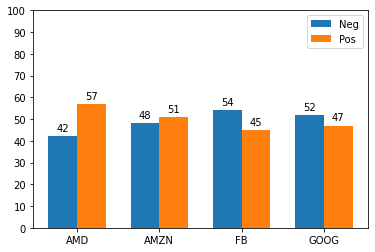

In [54]:
index = np.arange(len(company_tikcers))
score_label = np.arange(0, 110, 10)

bar_width = 0.35

fig, ax = plt.subplots()
barNeg = ax.bar(index - bar_width/2, dataset_company['Neg'], bar_width, label='Neg')
barPos = ax.bar(index + bar_width/2, dataset_company['Pos'], bar_width, label='Pos')

ax.set_xticks(index)
ax.set_xticklabels(company_tikcers)

ax.set_yticks(score_label)
ax.set_yticklabels(score_label)


ax.legend()

def insert_data_labels(bars):
  for bar in bars:
    bar_height = bar.get_height()
    ax.annotate('{0:.0f}'.format(bar.get_height()),
                xy=(bar.get_x() + bar.get_width() / 2, bar_height),
                xytext=(0,3),
                textcoords='offset points',
                ha='center',
                va='bottom'
    )

insert_data_labels(barNeg)
insert_data_labels(barPos)

plt.show()


### Pie Chart

In [55]:
def percentage(part, whole):
  temp = 100 * float(part) / float(whole)
  return format(temp, '.2f')

In [56]:
def visualization(positive, neutral, negative):
  labels = ['Positive [' + str(positive) + '%]','Neutral [' + str(neutral) + '%]',
            'Negative [' + str(negative) + '%]']
  sizes = [positive, neutral, negative]
  colors = ['lightgreen', 'gold', 'red']
  patches, texts = plt.pie(sizes, colors=colors, startangle=90)
  plt.title('Aggregate sentiment value of the economic news headlines')
  plt.legend(patches, labels, loc="best")
  plt.axis('equal')
  plt.tight_layout()
  plt.show()

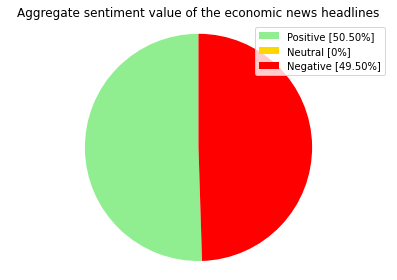

In [58]:
all_num = sentiment_result['pos'] + sentiment_result['neg']
pos_percent = percentage(part=sentiment_result['pos'], whole=all_num)
neg_percent = percentage(part=sentiment_result['neg'], whole=all_num)

visualization(positive=pos_percent,neutral=0, negative=neg_percent)